# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
from scipy.io import loadmat

plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5

In [2]:
DATA_DIR = 'data'
PLOTS_DIR = 'plots'

# Problem Statement

The goal is to solve the 2D boundary value problem of linear elasiticity using neural networks. The PDE is defined as follows:
$$
\begin{aligned}
\begin{split}
G\left[\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} \right] + G\left( \frac{1+v}{1-v} \right) \left[\frac{\partial^2u}{\partial x^2} + \frac{\partial^2v}{\partial yx} \right] + \sin(2\pi x) \sin(2\pi y) = 0 \\
G\left[\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} \right] + G\left( \frac{1+v}{1-v} \right) \left[\frac{\partial^2v}{\partial y^2} + \frac{\partial^2u}{\partial xy} \right] + \sin(\pi x) +  \sin(2\pi y) = 0
\end{split}
\end{aligned}
$$
with boundary conditions $ u, v = 0$ and
$$
G = \frac{E}{2(1+\nu)}
$$

# Solution

## The Neural Network

We will start by defining the neural network. The network will be a simple feed forward network with 5 hidden layers and 30 neurons each layer. The input to the network will be the coordinates $(x,y)$ and the output will be the displacement $u$ and $v$. `tanh` activation function will be used for the hidden layers and `linear` activation function will be used for the output layer.

In [3]:
class Displacements(nn.Module):
    def __init__(self, ns=30):
        super(Displacements, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, ns),
            nn.Tanh(),
            nn.Linear(ns, ns),
            nn.Tanh(),
            nn.Linear(ns, ns),
            nn.Tanh(),
            nn.Linear(ns, ns),
            nn.Tanh(),
            nn.Linear(ns, ns),
            nn.Tanh(),
            nn.Linear(ns, 2),
        )

    def forward(self, x):
        return self.net(x)

model = Displacements(ns=30)
print(model)

Displacements(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): Tanh()
    (8): Linear(in_features=30, out_features=30, bias=True)
    (9): Tanh()
    (10): Linear(in_features=30, out_features=2, bias=True)
  )
)


This gives us the required network architecture. Next, we load the boundary and interior points.

## Loading the data

In [4]:
boundary_points = loadmat(os.path.join(DATA_DIR, 'boundary_points.mat'))
x_boundary = boundary_points['x_bdry']
y_boundary = boundary_points['y_bdry']
assert len(x_boundary) == len(y_boundary), 'x and y boundary points must have the same length'
BOUNDARY_POINTS = len(x_boundary)
print(f'Number of boundary points: {BOUNDARY_POINTS}')

Number of boundary points: 160


In [5]:
interior_points = loadmat(os.path.join(DATA_DIR, 'interior_points.mat'))
x_interior = interior_points['x']
y_interior = interior_points['y']
assert len(x_interior) == len(y_interior), 'x and y interior points must have the same length'
INTERIOR_POINTS = len(x_interior)
print(f'Number of interior points: {INTERIOR_POINTS}')

Number of interior points: 2705


Let's have a look at how the data looks like.

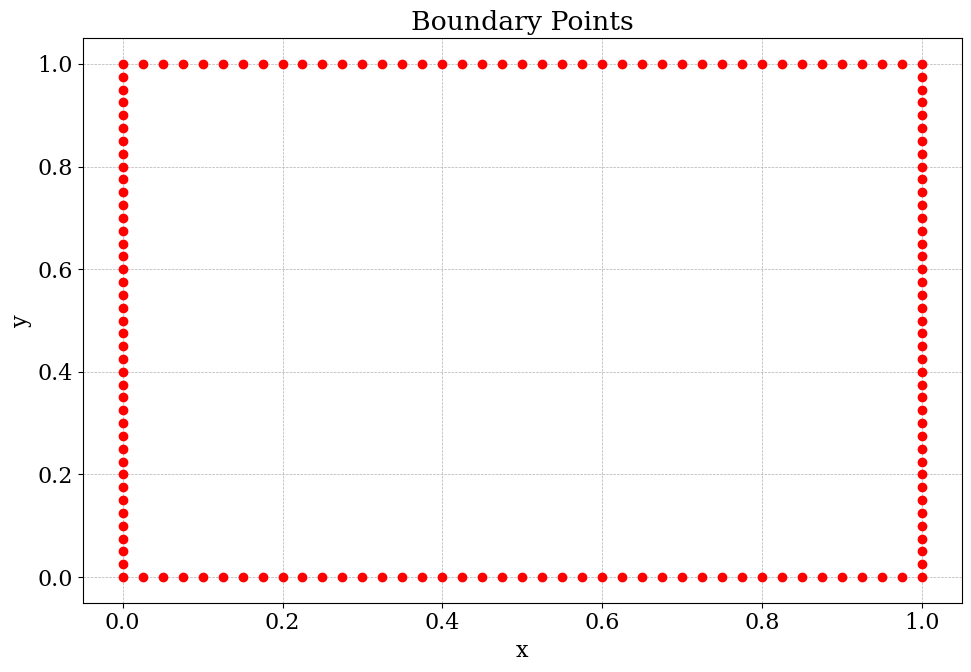

In [6]:
plt.plot(x_boundary, y_boundary, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Boundary Points')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '0101.png'))
plt.show()

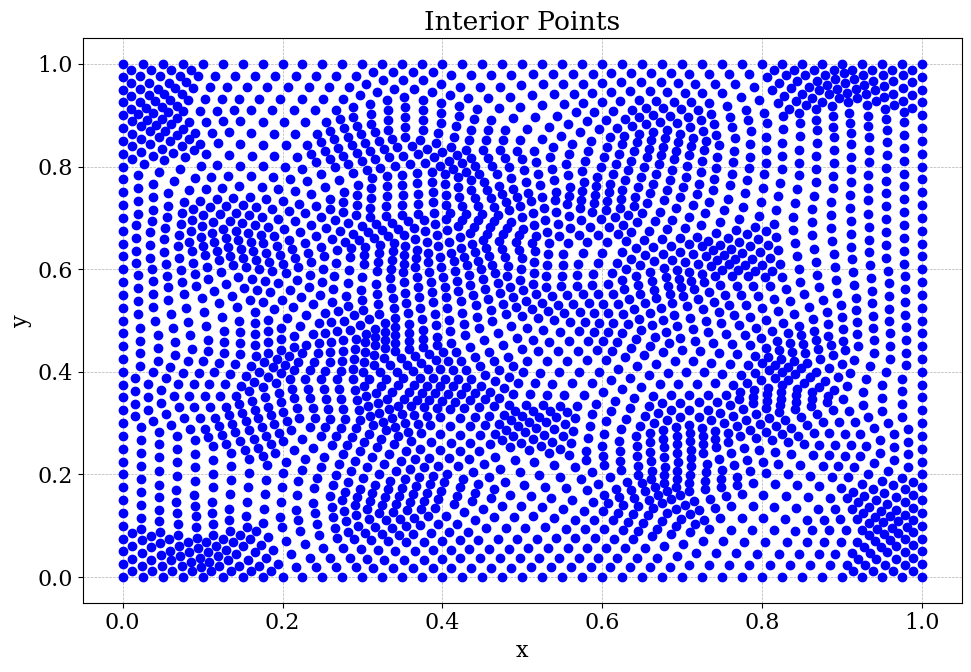

In [7]:
plt.plot(x_interior, y_interior, 'ob')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interior Points')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '0102.png'))
plt.show()

We'll need to concatenate the boundary and interior points to get the complete data. As the boundary condition is $u, v = 0$, we will also create a target array with all zeros for the boundary points.

In [8]:
X_boundary = torch.tensor(np.concatenate((x_boundary, y_boundary), axis=1), dtype=torch.float32, requires_grad=True)
X_interior = torch.tensor(np.concatenate((x_interior, y_interior), axis=1), dtype=torch.float32, requires_grad=True)

X = torch.cat((X_boundary, X_interior), dim=0)
u_boundary = torch.tensor(np.zeros((BOUNDARY_POINTS, 1)), dtype=torch.float32, requires_grad=True)
v_boundary = torch.tensor(np.zeros((BOUNDARY_POINTS, 1)), dtype=torch.float32, requires_grad=True)
U_boundary = torch.cat((u_boundary, v_boundary), dim=1)
print(X.shape, U_boundary.shape)

torch.Size([2865, 2]) torch.Size([160, 2])


This makes the data ready for training. Next, we'll create the loss function.

## Loss Function

The loss function is made up of two parts:
1. The PDE loss
2. The boundary loss

### Boundary Loss

The boundary loss will be a simple RMSE loss. Here is the code for the bounadry loss.

In [15]:
def boundary_loss(U_pred_b, U_b, regularization = 1):
    """Calculate the loss for the boundary points."""
    return regularization*torch.mean((U_pred_b - U_b)**2)

### PDE Loss

The PDE loss is complicated. We first need to determine the derivatives of $u$ and $v$ with respect to $x$ and $y$. Let's see how we can do that. But first, let's define $G$. which is used in the PDE:

In [10]:
E = 1.0
nu = 0.3
G = E / (2 * (1 + nu))

Here, we will define the pde loss which is given by equation 1 in the problem statement.

In [11]:
def pde_loss(X_i, model):
    """Calculate the loss for the PDE.
    
    Parameters
    ----------
    X_i : torch.Tensor
        The interior points.
    model : torch.nn.Module
        The model. It predicts the displacements for the interior points.
    
    Returns
    -------
    torch.Tensor
        The loss.
    """
    #extract x, y, u and v
    x, y = X_i[:, 0], X_i[:, 1]
    U_i = model(X_i)
    u = U_i[:, 0]
    v = U_i[:, 1]

    #Calculate the derivatives
    dudx, dudy = torch.autograd.grad(u.sum(), X_i, create_graph=True, retain_graph=True)[0].T
    dvdx, dvdy = torch.autograd.grad(v.sum(), X_i, create_graph=True, retain_graph=True)[0].T

    du2dx2, du2dxdy = torch.autograd.grad(dudx.sum(), X_i, create_graph=True, retain_graph=True)[0].T
    du2dydx, du2dy2 = torch.autograd.grad(dudy.sum(), X_i, create_graph=True, retain_graph=True)[0].T

    dv2dx2, dv2dxdy = torch.autograd.grad(dvdx.sum(), X_i, create_graph=True, retain_graph=True)[0].T
    dv2dydx, dv2dy2 = torch.autograd.grad(dvdy.sum(), X_i, create_graph=True, retain_graph=True)[0].T

    #Calculate the first PDE loss
    t1 = G*(du2dx2 + du2dy2)
    t2 = G*((1+v)/(1-v))*(du2dx2 + dv2dydx)
    t3 = torch.sin(2*torch.pi*x)*torch.sin(2*torch.pi*y)
    loss_1 = t1 + t2 + t3

    #Calculate the second PDE loss
    t1 = G*(dv2dx2 + dv2dy2)
    t2 = G*((1+v)/(1-v))*(du2dxdy + dv2dy2)
    t3 = torch.sin(torch.pi*x) + torch.sin(2*torch.pi*y)
    loss_2 = t1 + t2 + t3

    #total pde loss (minimizing both individual losses)
    loss_pde = torch.mean(loss_1**2) + torch.mean(loss_2**2)
    return loss_pde

### Total Loss

Now, the total loss:

In [17]:
pde_losses = []
boundary_losses = []
total_losses = []


def loss(model, epoch, verbosity):
    """Calculate the total loss.

    Parameters
    ----------
    X : torch.Tensor
        The points.
    model : torch.nn.Module
        The model. It predicts the displacements for the points.

    Returns
    -------
    torch.Tensor
        The loss.
    """
    loss_pde = pde_loss(X_interior, model)
    loss_b = boundary_loss(model(X_boundary), U_boundary, 1000)
    total_loss = loss_pde +  loss_b

    pde_losses.append(loss_pde.item())
    boundary_losses.append(loss_b.item())
    total_losses.append(total_loss.item())
    if verbosity == 0:
        return total_loss
    if (epoch + 1) % verbosity == 0:
        print(
            f"Epoch {epoch+1:>4d} => PDE Loss: {loss_pde.item():.6f} |  Boundary Loss: {loss_b.item():.6f} | Total Loss: {total_loss.item():.6f}"
        )
    return total_loss

Excellent! We have the loss function ready. Next, we'll create the optimizer and train the model.

## Training

In [18]:
model = Displacements()

In [19]:
pde_losses = []
boundary_losses = []
total_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(2000):
    optimizer.zero_grad()
    l = loss(model, epoch, 100)
    l.backward()
    optimizer.step()

Epoch  100 => PDE Loss: 1.000211 |  Boundary Loss: 0.035777 | Total Loss: 1.035989
Epoch  200 => PDE Loss: 0.498239 |  Boundary Loss: 0.400331 | Total Loss: 0.898569
Epoch  300 => PDE Loss: 0.365034 |  Boundary Loss: 0.102592 | Total Loss: 0.467626
Epoch  400 => PDE Loss: 0.351595 |  Boundary Loss: 0.094999 | Total Loss: 0.446594
Epoch  500 => PDE Loss: 0.172586 |  Boundary Loss: 0.072575 | Total Loss: 0.245161
Epoch  600 => PDE Loss: 0.095595 |  Boundary Loss: 0.052234 | Total Loss: 0.147829
Epoch  700 => PDE Loss: 0.068512 |  Boundary Loss: 0.042095 | Total Loss: 0.110607
Epoch  800 => PDE Loss: 0.053836 |  Boundary Loss: 0.036100 | Total Loss: 0.089936
Epoch  900 => PDE Loss: 0.049561 |  Boundary Loss: 0.033453 | Total Loss: 0.083014
Epoch 1000 => PDE Loss: 0.038034 |  Boundary Loss: 0.027694 | Total Loss: 0.065728
Epoch 1100 => PDE Loss: 0.031468 |  Boundary Loss: 0.027847 | Total Loss: 0.059315
Epoch 1200 => PDE Loss: 0.031225 |  Boundary Loss: 0.020720 | Total Loss: 0.051945
Epoc

Let's save the model:

In [25]:
torch.save(model.state_dict(), 'solutions_model.pt')

## Results

Now, we'll plot the results. We will use 300 points for plotting the results. First, we need to create a meshgrid:

In [20]:
x_mesh, y_mesh = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
X_to_predict = torch.tensor(np.concatenate((x_mesh.reshape(-1, 1), y_mesh.reshape(-1, 1)), axis=1), dtype=torch.float32, requires_grad=True)

Next, predict the values for the meshgrid anf separate the values for $u$ and $v$.

In [21]:
U_pred = model(X_to_predict)
u_pred = U_pred[:, 0].detach().numpy()
u_pred = u_pred.reshape(x_mesh.shape)
v_pred = U_pred[:, 1].detach().numpy()
v_pred = v_pred.reshape(x_mesh.shape)

Now, we can plot the displacements:

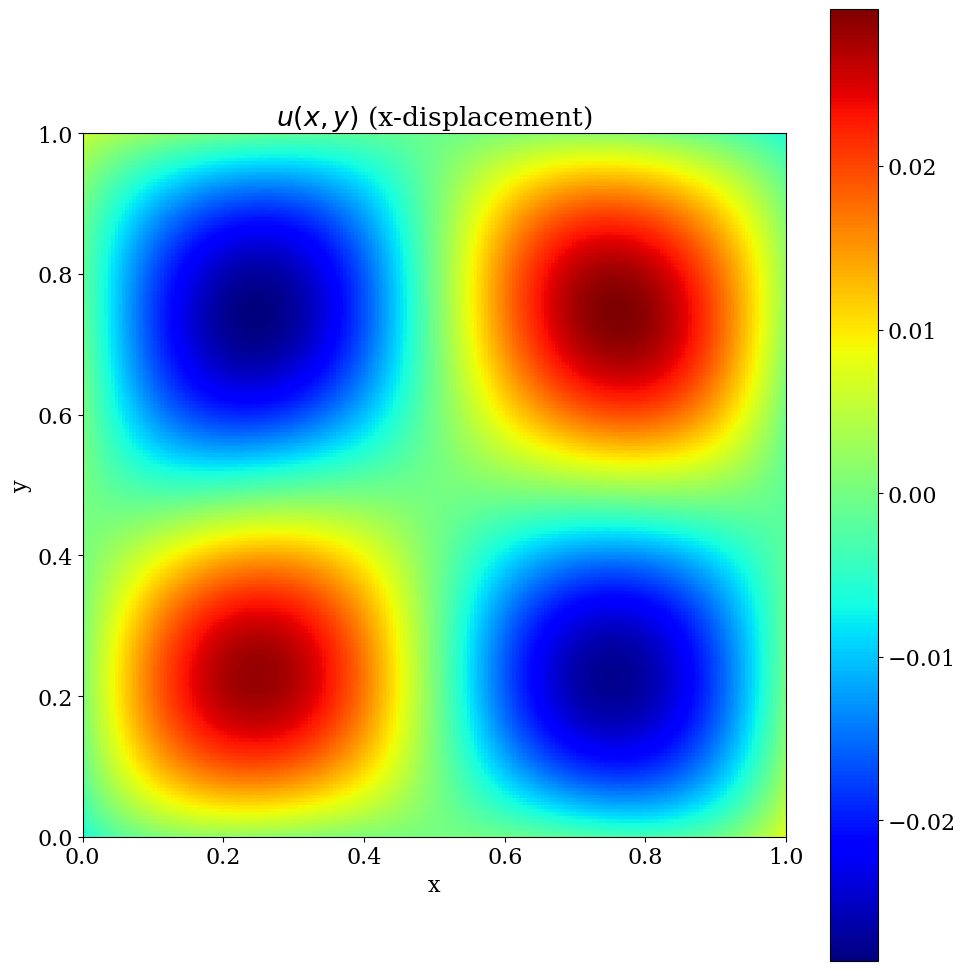

In [23]:
#plot image
plt.figure(figsize=(10, 10))
plt.imshow(u_pred, cmap='jet', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("$u(x, y)$ (x-displacement)")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "0103.png"))

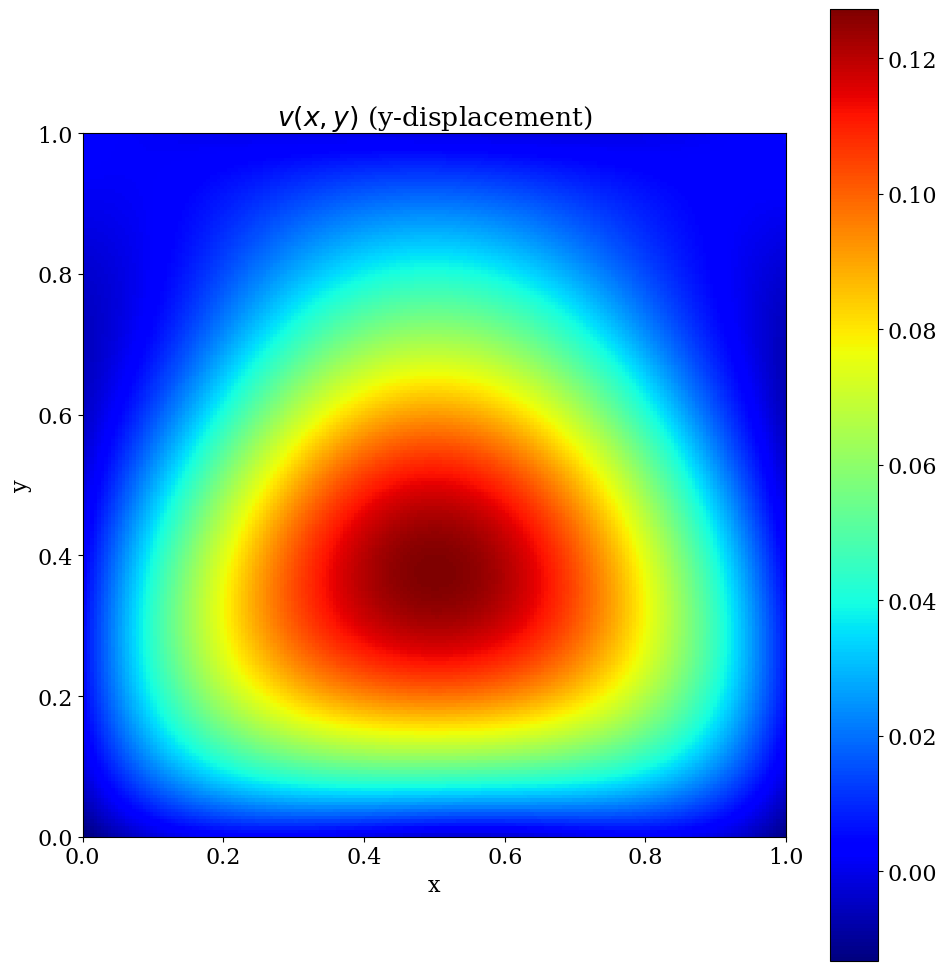

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(v_pred, cmap='jet', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("$v(x, y)$ (y-displacement)")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "0104.png"))

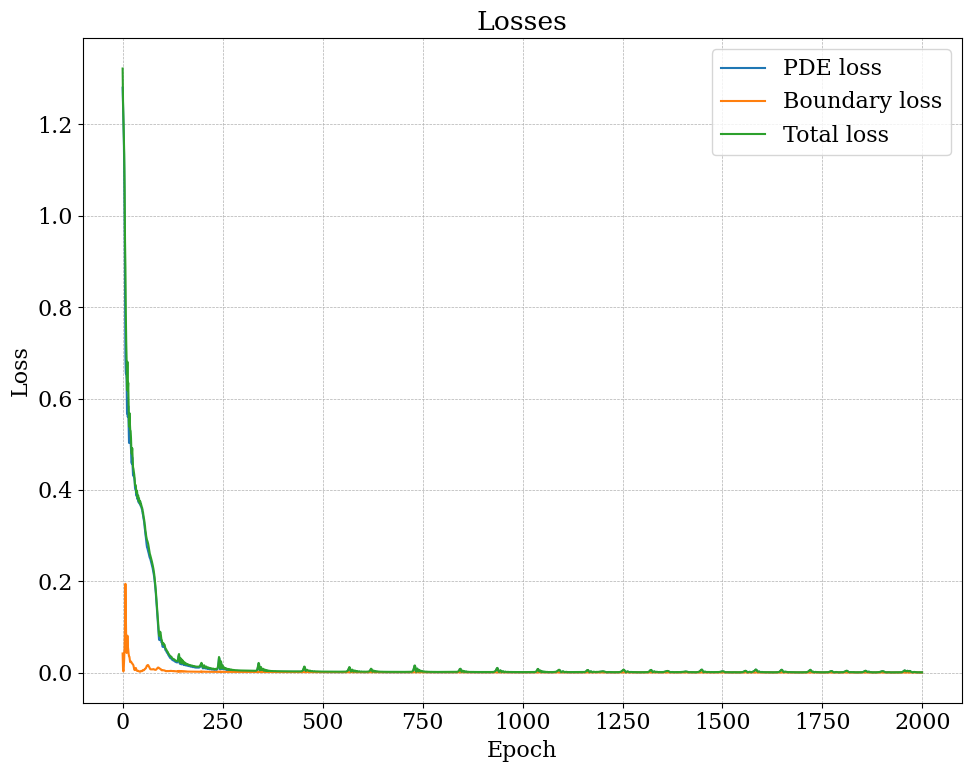

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(pde_losses, label="PDE loss")
plt.plot(boundary_losses, label="Boundary loss")
plt.plot(total_losses, label="Total loss")
plt.legend()
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "0105.png"))